### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

### General EDA

##### 1) Load dataset & show shape

In [2]:
path = "data/mock_credit_risk_dataset_realistic.csv"
df = pd.read_csv(path)

print("#1 — Shape (rows, cols):", df.shape)

#1 — Shape (rows, cols): (5000, 16)


##### 2) First 5 rows


In [3]:
print("#2 — Head (5 rows):")
df.head()

#2 — Head (5 rows):


,age,income,loan_amount,loan_to_value_ratio,credit_score,num_credit_cards,num_loans,avg_payment_delay_days,num_missed_payments,employment_length_years,annual_spending,debt_to_income_ratio,savings_balance,checking_balance,region,default_flag
0,56,48353.46,34073.00,0.91,605,6,0,21,0,25,34105.25,0.68,18339.93,-956.07,West,1
1,69,57462.28,24078.10,0.31,341,2,0,4,2,14,21578.01,0.56,12367.34,5455.21,North,1
2,46,44219.25,28162.22,0.36,767,7,1,11,0,7,25739.33,0.36,9438.68,391.72,South,0
3,32,56306.79,9414.32,0.87,739,0,2,20,3,27,19061.13,0.76,16208.59,6900.70,North,0
4,60,37034.13,29839.24,0.51,626,0,4,8,1,29,22646.45,0.72,12820.89,8909.89,South,0


##### 3) Column datatypes

In [4]:
print("#3 — Dtypes:")
print(df.dtypes)

#3 — Dtypes:
age                          int64
income                     float64
loan_amount                float64
loan_to_value_ratio        float64
credit_score                 int64
num_credit_cards             int64
num_loans                    int64
avg_payment_delay_days       int64
num_missed_payments          int64
employment_length_years      int64
annual_spending            float64
debt_to_income_ratio       float64
savings_balance            float64
checking_balance           float64
region                      object
default_flag                 int64
dtype: object


##### 4) Missing values (count & %)


In [5]:
print("#4 — Missing Values:")
missing_count = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
missing_df = pd.DataFrame({"missing_count": missing_count, "missing_pct": missing_pct.round(2)})
display(missing_df)

#4 — Missing Values:


,missing_count,missing_pct
age,0,0.0
income,0,0.0
loan_amount,0,0.0
loan_to_value_ratio,0,0.0
credit_score,0,0.0
num_credit_cards,0,0.0
num_loans,0,0.0
avg_payment_delay_days,0,0.0
num_missed_payments,0,0.0
employment_length_years,0,0.0


##### 5) Descriptive statistics

In [6]:
print("#5 — Descriptive Statistics (numeric):")
display(df.describe().T)

print("\n#5b — Descriptive Statistics (categorical/object):")
obj_cols = df.select_dtypes(include=["object", "category", "bool"]).columns
if len(obj_cols) > 0:
    # For categoricals, show count, unique, top, freq (like describe for object)
    display(df[obj_cols].describe().T)
else:
    print("No categorical/object columns found.")

#5 — Descriptive Statistics (numeric):


,count,mean,std,min,25%,50%,75%,max
age,5000.0,43.584600,14.919094,18.00,31.0000,43.000,56.0000,69.00
income,5000.0,49744.180218,15111.487261,-3730.94,39599.4775,49598.125,59920.6675,99145.99
loan_amount,5000.0,19838.456120,10058.187935,-17574.35,13069.5750,19802.985,26658.4250,55440.65
loan_to_value_ratio,5000.0,0.559472,0.258342,0.10,0.3400,0.560,0.7800,1.00
credit_score,5000.0,576.082800,159.253975,300.00,435.0000,576.000,714.0000,849.00
num_credit_cards,5000.0,4.560200,2.850614,0.00,2.0000,5.000,7.0000,9.00
num_loans,5000.0,1.973400,1.407085,0.00,1.0000,2.000,3.0000,4.00
avg_payment_delay_days,5000.0,29.658000,17.413250,0.00,15.0000,30.000,45.0000,59.00
num_missed_payments,5000.0,1.513000,1.231964,0.00,1.0000,1.000,2.0000,8.00
employment_length_years,5000.0,14.609400,8.644569,0.00,7.0000,15.000,22.0000,29.00



#5b — Descriptive Statistics (categorical/object):


,count,unique,top,freq
region,5000,4,South,1289


##### 6) Count unique values per column (+ top frequency preview)

In [7]:
print("#6 — Unique values per column:")
nunique_series = df.nunique(dropna=True).sort_values(ascending=False)
display(nunique_series.to_frame(name="n_unique"))

#6 — Unique values per column:


,n_unique
loan_amount,4996
income,4995
savings_balance,4994
annual_spending,4989
checking_balance,4989
credit_score,550
loan_to_value_ratio,91
debt_to_income_ratio,86
avg_payment_delay_days,60
age,52


In [8]:
print("#6b — Top 3 most frequent values (first 10 columns only for brevity):")
for col in df.columns[:10]:
    print(f"\nColumn: {col}")
    print(df[col].value_counts(dropna=False).head(3))

#6b — Top 3 most frequent values (first 10 columns only for brevity):

Column: age
age
64    118
66    118
52    114
Name: count, dtype: int64

Column: income
income
48715.88    2
59916.54    2
51279.26    2
Name: count, dtype: int64

Column: loan_amount
loan_amount
7225.82     2
17632.39    2
27999.11    2
Name: count, dtype: int64

Column: loan_to_value_ratio
loan_to_value_ratio
0.65    78
0.80    73
0.91    73
Name: count, dtype: int64

Column: credit_score
credit_score
642    23
808    21
417    19
Name: count, dtype: int64

Column: num_credit_cards
num_credit_cards
6    535
5    514
9    513
Name: count, dtype: int64

Column: num_loans
num_loans
3    1044
1    1033
0    1014
Name: count, dtype: int64

Column: avg_payment_delay_days
avg_payment_delay_days
57    106
35     99
41     98
Name: count, dtype: int64

Column: num_missed_payments
num_missed_payments
1    1627
2    1257
0    1127
Name: count, dtype: int64

Column: employment_length_years
employment_length_years
18    194
17

##### 7) Duplicates check

In [9]:
print("#7 — Duplicated Rows:")
dup_count = df.duplicated().sum()
print(f"Total duplicated rows: {dup_count}")
if dup_count > 0:
    print("Preview of duplicated rows:")
    display(df[df.duplicated(keep=False)].head())

#7 — Duplicated Rows:
Total duplicated rows: 0


### Credit-Risk-Focused EDA

##### 1) Target distribution

#1 — Target Distribution:
default_flag
0    3044
1    1956
Name: count, dtype: int64

Percentage Distribution:
default_flag
0    60.88
1    39.12
Name: proportion, dtype: float64


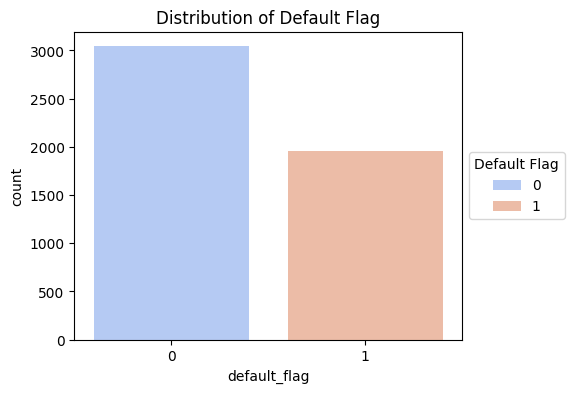

In [10]:
# Target variable
target = 'default_flag'

print("#1 — Target Distribution:")
print(df[target].value_counts())
print("\nPercentage Distribution:")
print((df[target].value_counts(normalize=True) * 100).round(2))

plt.figure(figsize=(5,4))
sns.countplot(x=target, hue=target, data=df, palette="coolwarm")
plt.title("Distribution of Default Flag")
plt.legend(title='Default Flag', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

##### 2️) Correlation heatmap (numeric only)

#2 — Correlation Heatmap:


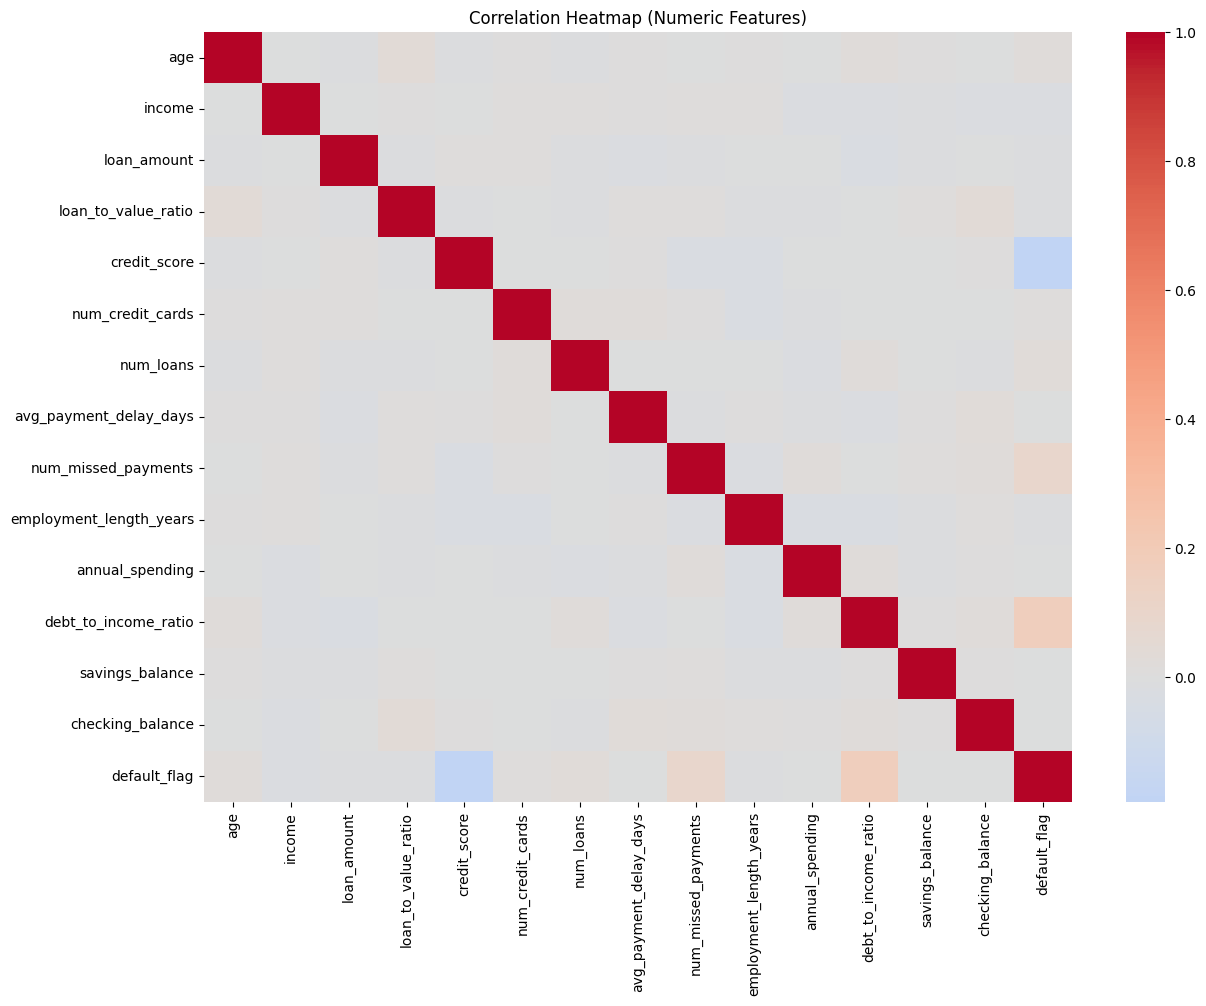

In [11]:
print("#2 — Correlation Heatmap:")
corr = df.corr(numeric_only=True)
plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.savefig("charts/heatmap.png") 
plt.show()

##### 3️) Distributions of key numeric variables


#3 — Distributions of key numeric features:


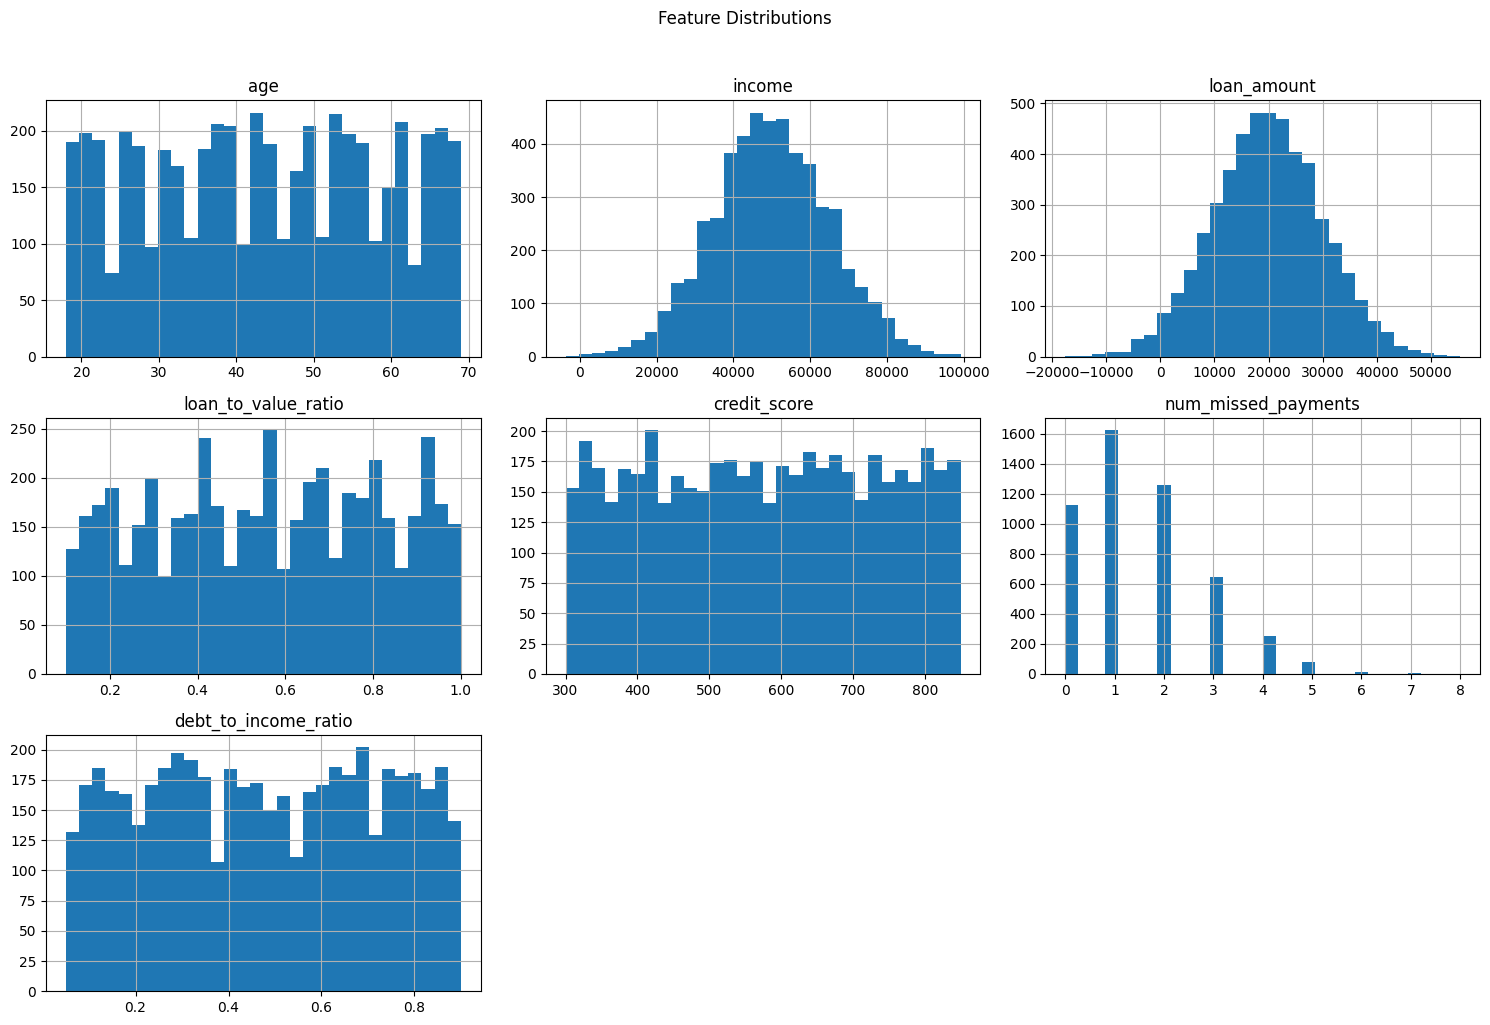

In [12]:
key_features = [
    'age', 'income', 'loan_amount', 'loan_to_value_ratio',
    'credit_score', 'num_missed_payments', 'debt_to_income_ratio'
]

print("\n#3 — Distributions of key numeric features:")
df[key_features].hist(bins=30, figsize=(15,10))
plt.suptitle("Feature Distributions", y=1.02)
plt.tight_layout()
plt.savefig("charts/distribution.png") 
plt.show()

##### 4️) Relationship with target (boxplots)

#4 — Relationship with target (Boxplots):


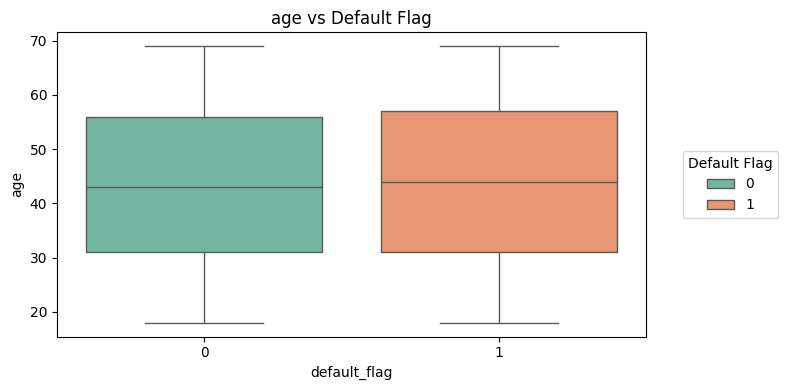

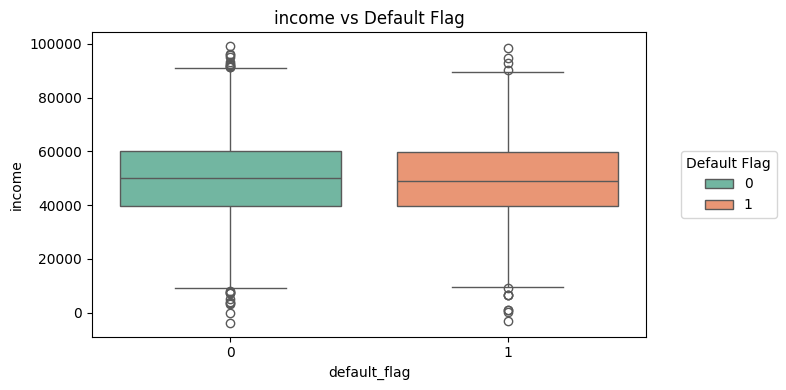

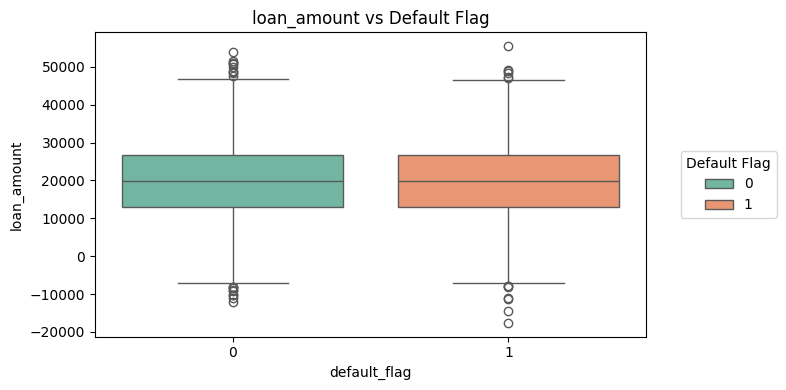

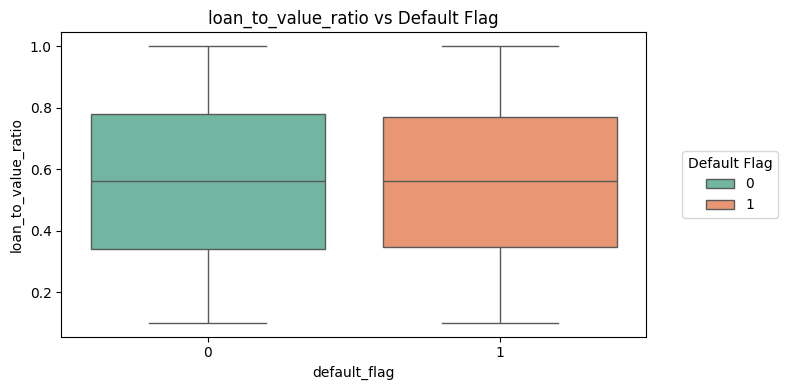

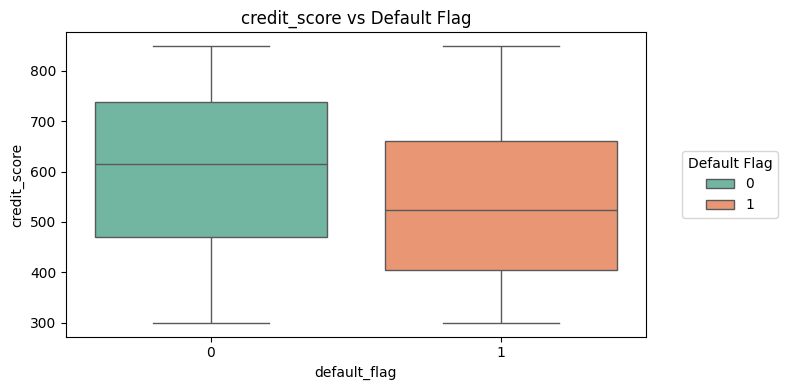

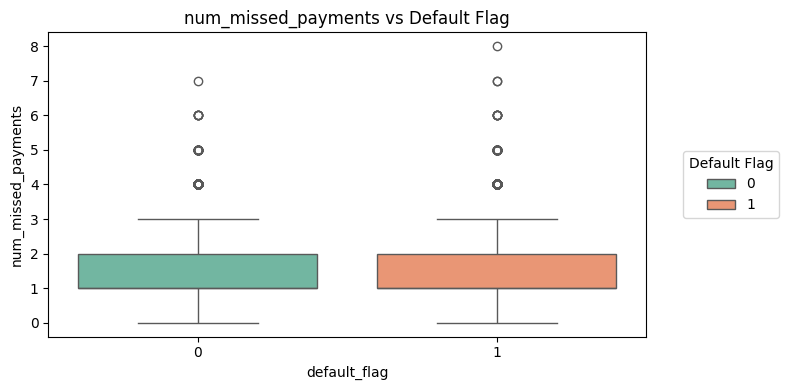

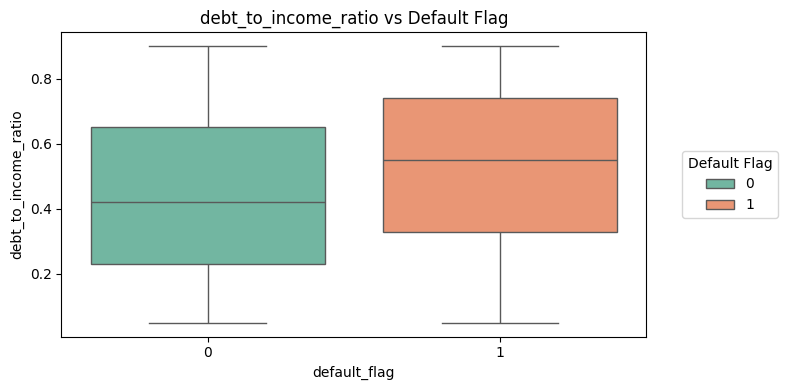

In [13]:
print("#4 — Relationship with target (Boxplots):")
for col in key_features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=target, hue=target, y=col, data=df, palette="Set2")
    plt.title(f"{col} vs Default Flag")
    plt.legend(title='Default Flag', loc='center left', bbox_to_anchor=(1.05, 0.5))
    plt.tight_layout()
    plt.savefig(f"charts/{col}_boxplot.png", bbox_inches='tight') 
    plt.show()

##### 5️) Categorical variable vs target (if exists)

#5 — Categorical Features vs Target:

region:



default_flag,0,1
region,,
East,62.15,37.85
North,58.98,41.02
South,62.06,37.94
West,60.30,39.70


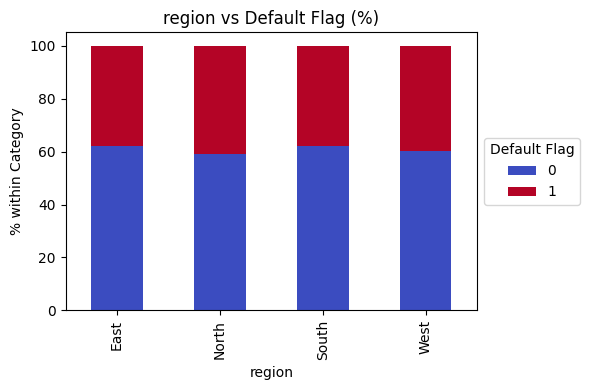

In [14]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
if len(cat_cols) > 0:
    print("#5 — Categorical Features vs Target:")
    for col in cat_cols:
        ct = pd.crosstab(df[col], df[target], normalize='index') * 100
        print(f"\n{col}:\n")
        display(ct.round(2))
        ct.plot(kind='bar', stacked=True, figsize=(6,4), colormap='coolwarm')
        plt.title(f"{col} vs Default Flag (%)")
        plt.legend(title='Default Flag', loc='center left', bbox_to_anchor=(1, 0.5))
        plt.ylabel("% within Category")
        plt.tight_layout()
        plt.savefig("charts/cat_chart.png") 
        plt.show()
else:
    print("No categorical columns detected.")

##### 6️) Quick Feature Importance (Random Forest)


#6 — Feature Importance (Quick Check):


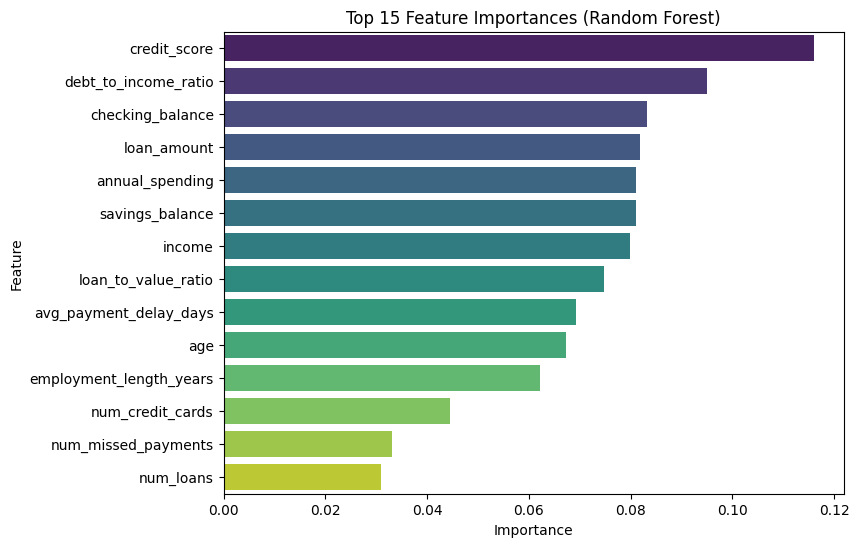

In [15]:
print("#6 — Feature Importance (Quick Check):")

X = df.select_dtypes(include=np.number).drop(columns=[target])
y = df[target]

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x=top_features.values, y=top_features.index, hue=top_features.index, palette='viridis')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.savefig("charts/feature_importance.png") 
plt.show()

### Feature Engineering & Preprocessing

##### 1) Handle Missing Values

In [ ]:
df.isna().sum().sort_values(ascending=False).head(10)

df.fillna({'income': df['income'].median()}, inplace=True)

##### 2) Encode Categorical Variables

In [17]:
df = pd.get_dummies(df, columns=['region'], drop_first=True)

##### 3) Remove Low-Variance or Highly Correlated Features

In [18]:
corr = df.corr(numeric_only=True)
high_corr = corr[abs(corr) > 0.9]

##### 4) Feature Scaling (for distance-based or regularized models)

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_cols = df.select_dtypes(include=np.number).columns.drop('default_flag')
df[num_cols] = scaler.fit_transform(df[num_cols])

### Modeling

##### SAFETY BLOCK: build train/test if missing (keeps code runnable)

In [ ]:
# Try optional XGBoost if available
xgb_available = True
try:
    from xgboost import XGBClassifier
except Exception:
    xgb_available = False

def ensure_train_test(df, target="default_flag"):
    # Identify columns by dtype
    num_cols = df.select_dtypes(include=["int64","float64"]).columns.drop(target, errors="ignore").tolist()
    bool_cols = df.select_dtypes(include=["bool"]).columns.tolist()

    # Numeric pipeline
    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    # Boolean pipeline – convert to int
    bool_pipe = Pipeline([
        ("to_int", FunctionTransformer(lambda X: X.astype(int))),
        ("imputer", SimpleImputer(strategy="most_frequent"))
    ])

    # Combine all
    preprocessor = ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("bool", bool_pipe, bool_cols),
    ])

    return preprocessor


X = df.drop(columns=["default_flag"])
y = df["default_flag"].astype(int)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

##### Models

In [ ]:
# Using class_weight='balanced' for imbalance-aware baselines
preprocessor = ensure_train_test(X_train_raw)

rf_pipe = Pipeline([("pre", preprocessor),
                    ("clf", RandomForestClassifier(
                        n_estimators=300, random_state=42,
                        class_weight="balanced_subsample", n_jobs=-1))])

logreg_pipe = Pipeline([("pre", preprocessor),
                        ("clf", LogisticRegression(
                            max_iter=500, class_weight="balanced", solver="liblinear"))])

models = {
    "LogReg": logreg_pipe,
    "RandomForest": rf_pipe
}

if xgb_available:
    xgb = Pipeline([
        ("pre", preprocessor),
        ("clf", XGBClassifier(
            n_estimators=500, max_depth=5, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            random_state=42, n_jobs=-1, eval_metric="logloss"
        ))
    ])
    models["XGBoost"] = xgb

##### Helper: evaluation & plotting

In [22]:
def evaluate_model(name, y_true, probas, threshold=0.5, save_prefix="charts"):
    """Compute metrics, choose threshold, plot ROC/PR with legend at center-right."""
    # Scores (probabilities for positive class assumed)
    roc_auc = roc_auc_score(y_true, probas)
    pr_auc = average_precision_score(y_true, probas)

    # Default threshold metrics
    y_pred = (probas >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n=== {name} — Metrics @ threshold={threshold:.2f} ===")
    print(f"ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

    # --- Curves & optimal threshold by F1 ---
    fpr, tpr, _ = roc_curve(y_true, probas)
    precision, recall, thr = precision_recall_curve(y_true, probas)
    # best F1 threshold (ignoring last point where threshold undefined)
    f1s = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-12)
    best_idx = np.nanargmax(f1s)
    best_thr = thr[best_idx]
    print(f"Best F1 threshold: {best_thr:.4f} (F1={f1s[best_idx]:.4f}, Precision={precision[best_idx]:.4f}, Recall={recall[best_idx]:.4f})")

    # ROC plot
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1], ls="--")
    plt.title(f"{name} — ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    plt.tight_layout()
    plt.savefig(f"{save_prefix}/{name}_ROC.png", bbox_inches='tight', dpi=300)
    plt.show()

    # PR plot
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.3f}")
    plt.title(f"{name} — Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    plt.tight_layout()
    plt.savefig(f"{save_prefix}/{name}_PR.png", bbox_inches='tight', dpi=300)
    plt.show()

    return {
        "model": name,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "acc@0.5": acc,
        "prec@0.5": prec,
        "rec@0.5": rec,
        "f1@0.5": f1,
        "best_f1_threshold": float(best_thr),
        "best_f1": float(f1s[best_idx]),
        "best_prec": float(precision[best_idx]),
        "best_rec": float(recall[best_idx])
    }

##### Train, CV, Evaluate



##### Training LogReg #####
LogReg CV ROC-AUC: mean=0.6511 ± 0.0163

=== LogReg — Metrics @ threshold=0.50 ===
ROC-AUC: 0.6548 | PR-AUC: 0.5185
Accuracy: 0.6180 | Precision: 0.5097 | Recall: 0.6061 | F1: 0.5537
Confusion Matrix:
 [[381 228]
 [154 237]]

Classification Report:
               precision    recall  f1-score   support

           0     0.7121    0.6256    0.6661       609
           1     0.5097    0.6061    0.5537       391

    accuracy                         0.6180      1000
   macro avg     0.6109    0.6159    0.6099      1000
weighted avg     0.6330    0.6180    0.6222      1000

Best F1 threshold: 0.4019 (F1=0.6057, Precision=0.4715, Recall=0.8465)


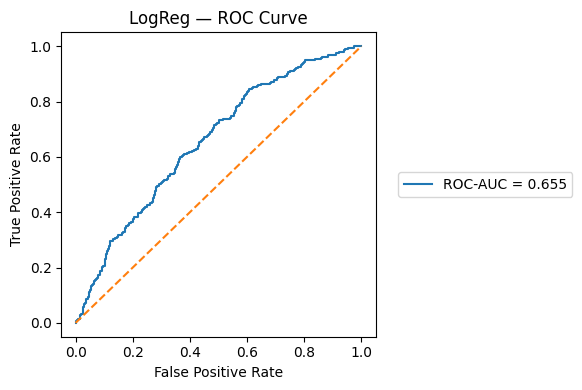

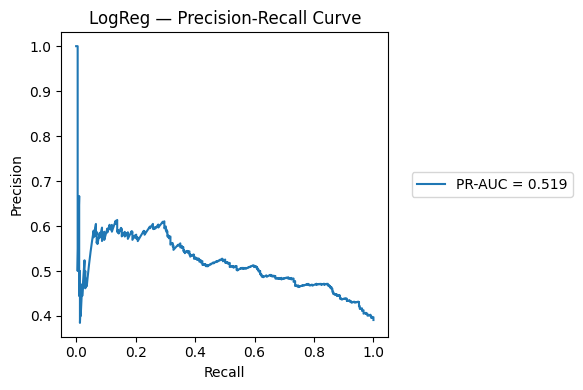



##### Training RandomForest #####
RandomForest CV ROC-AUC: mean=0.6305 ± 0.0174

=== RandomForest — Metrics @ threshold=0.50 ===
ROC-AUC: 0.6249 | PR-AUC: 0.4927
Accuracy: 0.6220 | Precision: 0.5380 | Recall: 0.2353 | F1: 0.3274
Confusion Matrix:
 [[530  79]
 [299  92]]

Classification Report:
               precision    recall  f1-score   support

           0     0.6393    0.8703    0.7371       609
           1     0.5380    0.2353    0.3274       391

    accuracy                         0.6220      1000
   macro avg     0.5887    0.5528    0.5323      1000
weighted avg     0.5997    0.6220    0.5769      1000

Best F1 threshold: 0.2767 (F1=0.5928, Precision=0.4412, Recall=0.9028)


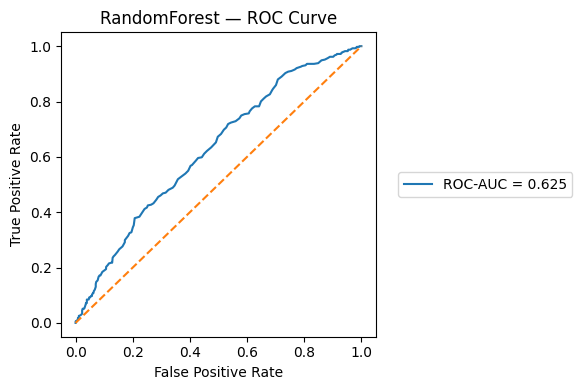

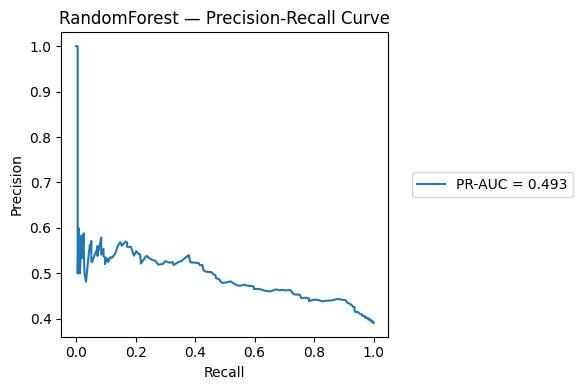



##### Training XGBoost #####
XGBoost CV ROC-AUC: mean=0.6037 ± 0.0175

=== XGBoost — Metrics @ threshold=0.50 ===
ROC-AUC: 0.5903 | PR-AUC: 0.4724
Accuracy: 0.5990 | Precision: 0.4805 | Recall: 0.3146 | F1: 0.3802
Confusion Matrix:
 [[476 133]
 [268 123]]

Classification Report:
               precision    recall  f1-score   support

           0     0.6398    0.7816    0.7036       609
           1     0.4805    0.3146    0.3802       391

    accuracy                         0.5990      1000
   macro avg     0.5601    0.5481    0.5419      1000
weighted avg     0.5775    0.5990    0.5772      1000

Best F1 threshold: 0.1231 (F1=0.5732, Precision=0.4131, Recall=0.9361)


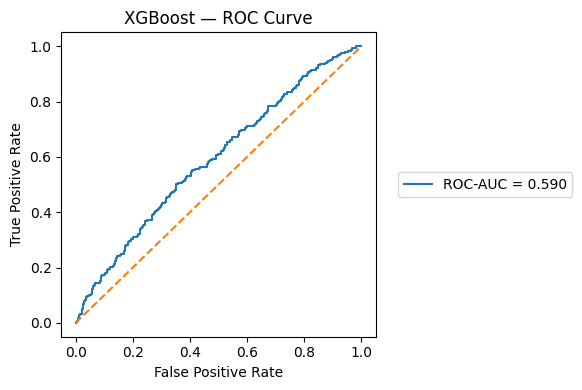

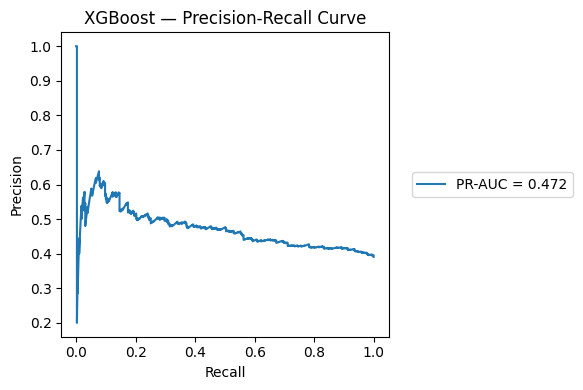


=== Model Comparison (sorted by PR-AUC then ROC-AUC) ===


,model,roc_auc,pr_auc,acc@0.5,prec@0.5,rec@0.5,f1@0.5,best_f1_threshold,best_f1,best_prec,best_rec
0,LogReg,0.654769,0.518513,0.618,0.509677,0.606138,0.553738,0.401884,0.605672,0.471510,0.846547
1,RandomForest,0.624908,0.492719,0.622,0.538012,0.235294,0.327402,0.276667,0.592779,0.441250,0.902813
2,XGBoost,0.590276,0.472398,0.599,0.480469,0.314578,0.380216,0.123076,0.573218,0.413093,0.936061


In [23]:
def get_positive_scores(model, X):
    """
    Returns the predicted positive-class scores for any binary classifier.
    Uses predict_proba if available, otherwise decision_function or predict.
    """
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        # Convert decision function to 0-1 range
        scores = model.decision_function(X)
        return (scores - scores.min()) / (scores.max() - scores.min())
    else:
        # fallback to binary predictions (0 or 1)
        return model.predict(X)

results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, pipe in models.items():
    print(f"\n\n##### Training {name} #####")

    # CV on train
    cv_auc = cross_val_score(
        estimator=pipe,
        X=X_train_raw, y=y_train,
        cv=skf, scoring="roc_auc", n_jobs=-1
    )
    print(f"{name} CV ROC-AUC: mean={cv_auc.mean():.4f} ± {cv_auc.std():.4f}")

    # Fit and evaluate on holdout
    pipe.fit(X_train_raw, y_train)
    probas_test = get_positive_scores(pipe, X_test_raw)
    res = evaluate_model(name, y_test, probas_test, threshold=0.5, save_prefix="charts")
    results.append(res)

cmp = pd.DataFrame(results).sort_values(by=["pr_auc", "roc_auc"], ascending=False)
print("\n=== Model Comparison (sorted by PR-AUC then ROC-AUC) ===")
display(cmp)


##### Interpretability: Feature Importance / Coefficients 

In [28]:
# --- Utilities ---------------------------------------------------------------
def _get_ohe(ct):
    """Best-effort grab of the OneHotEncoder inside a ColumnTransformer."""
    try:
        cat_pipe = ct.named_transformers_.get("cat")
        if cat_pipe is None:
            return None
        # Accept both Pipeline step names 'onehot' or 'ohe'
        for step_name in ["onehot", "ohe"]:
            if hasattr(cat_pipe, "named_steps") and step_name in cat_pipe.named_steps:
                return cat_pipe.named_steps[step_name]
        # Sometimes the transformer itself is the OHE
        if isinstance(cat_pipe, OneHotEncoder):
            return cat_pipe
    except Exception:
        pass
    return None

def get_feature_names_from_pipeline(pipe, num_cols, bool_cols, cat_cols):
    """
    Build feature names in the exact order used by the ColumnTransformer.
    Falls back to simple concatenation if no preprocessor is found.
    Expects ColumnTransformer with transformers named: 'num', 'bool', 'cat'.
    """
    if "preprocessor" in pipe.named_steps:
        ct = pipe.named_steps["preprocessor"]

        names = []

        # numeric block (kept in original order)
        if "num" in ct.named_transformers_ and len(num_cols):
            names.extend(list(num_cols))

        # boolean block (cast to 0/1 earlier)
        if "bool" in ct.named_transformers_ and len(bool_cols):
            names.extend(list(bool_cols))

        # categorical block (expanded by OHE)
        if "cat" in ct.named_transformers_ and len(cat_cols):
            ohe = _get_ohe(ct)
            if ohe is not None and hasattr(ohe, "get_feature_names_out"):
                cat_names = ohe.get_feature_names_out(cat_cols).tolist()
                names.extend(cat_names)
            else:
                # Fallback: no expansion info, use raw names (lengths may mismatch)
                names.extend(list(cat_cols))
        return names

    # No preprocessor in the pipeline: assume raw concatenation
    return list(num_cols) + list(bool_cols) + list(cat_cols)

def _get_estimator(pipe):
    """Return the final estimator of a sklearn Pipeline safely."""
    return list(pipe.named_steps.values())[-1]


In [26]:
def plot_importances(name, pipe, num_cols, bool_cols, cat_cols, top_k=20):
    """
    Plots top-k importances for tree models (feature_importances_) or coefficient
    magnitudes for linear models (coef_). Handles OHE-expanded categorical names.
    """
    feature_names = get_feature_names_from_pipeline(pipe, num_cols, bool_cols, cat_cols)
    est = _get_estimator(pipe)

    if hasattr(est, "feature_importances_"):
        importances = np.asarray(est.feature_importances_)
        label = "Feature importance"
    elif hasattr(est, "coef_"):
        coef = np.asarray(est.coef_).ravel()
        importances = np.abs(coef)
        label = "|Coefficient|"
    else:
        raise ValueError(f"{name}: Estimator has neither feature_importances_ nor coef_.")

    # Dimension check
    if len(importances) != len(feature_names):
        print(
            f"[WARN] {name}: model features = {len(importances)} "
            f"!= names = {len(feature_names)}. Showing head few for debugging:\n"
            f"  First 10 names: {feature_names[:10]}"
        )
        # Try to proceed with min length to still give a plot
        m = min(len(importances), len(feature_names))
        importances = importances[:m]
        feature_names = feature_names[:m]

    s = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    top = s.head(top_k)[::-1]  # reverse for barh

    plt.figure(figsize=(8, max(3, 0.35*len(top))))
    top.plot(kind="barh")
    plt.title(f"{name} — Top {min(top_k, len(s))} {label}")
    plt.xlabel(label)
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

LogReg: len(feature_names)=17 ; model_features=17
RandomForest: len(feature_names)=17 ; model_features=17
XGBoost: len(feature_names)=17 ; model_features=17
[WARN] LogReg: model features = 17 != names = 18. Showing head few for debugging:
  First 10 names: ['age', 'income', 'loan_amount', 'loan_to_value_ratio', 'credit_score', 'num_credit_cards', 'num_loans', 'avg_payment_delay_days', 'num_missed_payments', 'employment_length_years']


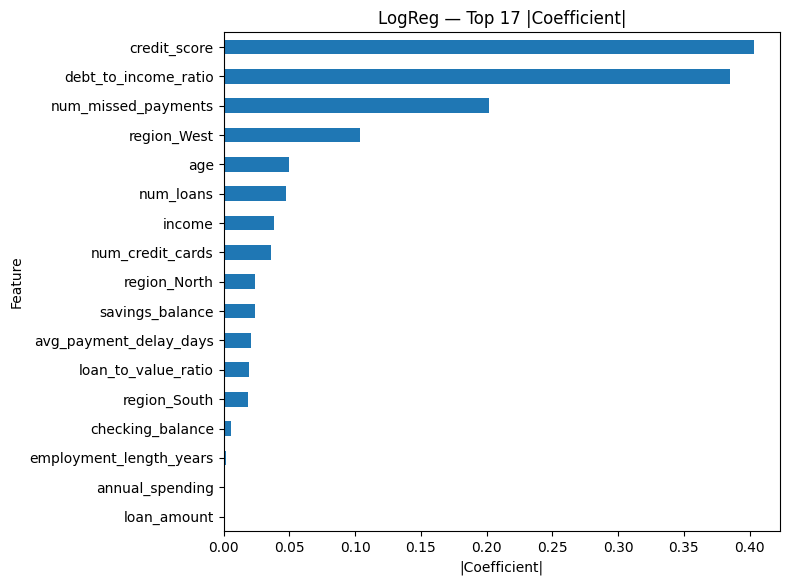

[WARN] RandomForest: model features = 17 != names = 18. Showing head few for debugging:
  First 10 names: ['age', 'income', 'loan_amount', 'loan_to_value_ratio', 'credit_score', 'num_credit_cards', 'num_loans', 'avg_payment_delay_days', 'num_missed_payments', 'employment_length_years']


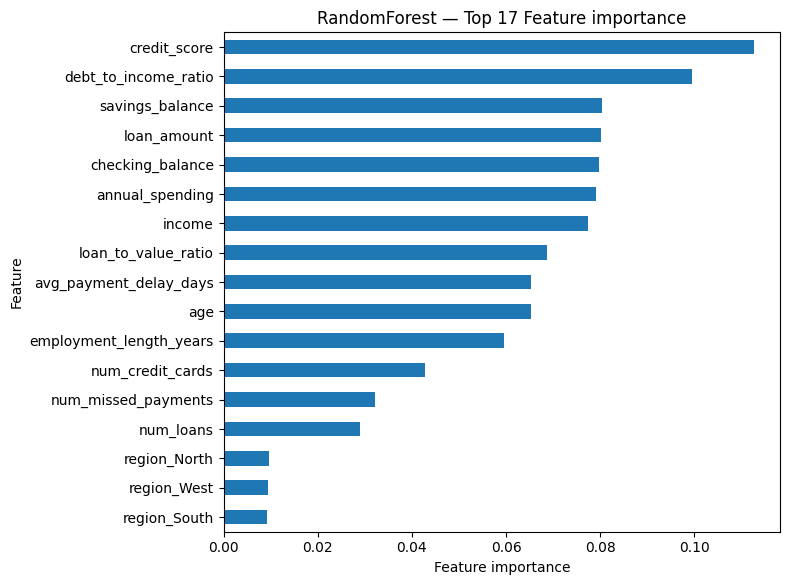

[WARN] XGBoost: model features = 17 != names = 18. Showing head few for debugging:
  First 10 names: ['age', 'income', 'loan_amount', 'loan_to_value_ratio', 'credit_score', 'num_credit_cards', 'num_loans', 'avg_payment_delay_days', 'num_missed_payments', 'employment_length_years']


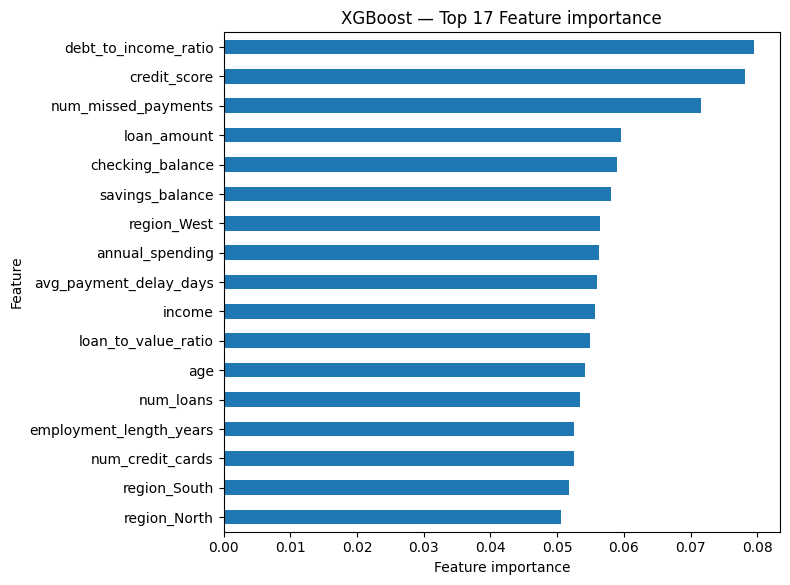

In [29]:
# --- Recreate column lists used by the preprocessor ---
num_cols  = X_train_raw.select_dtypes(include=["int64","float64","int32","float32","Int64","Float64"]).columns.tolist()
bool_cols = X_train_raw.select_dtypes(include=["bool"]).columns.tolist()

for name, pipe in models.items():
    # pipeline must be fitted already
    est = list(pipe.named_steps.values())[-1]  # last step = estimator
    # Build the names exactly like the ColumnTransformer order
    feature_names = list(num_cols) + list(bool_cols)

    # length the estimator expects
    if hasattr(est, "feature_importances_"):
        n_model = len(est.feature_importances_)
    elif hasattr(est, "coef_"):
        n_model = est.coef_.ravel().shape[0]
    else:
        n_model = None

    print(f"{name}: len(feature_names)={len(feature_names)} ; model_features={n_model}")

for name, pipe in models.items():
    try:
        plot_importances(name, pipe, num_cols, bool_cols, cat_cols, top_k=20)
    except Exception as e:
        print(f"[WARN] Could not plot importances for {name}: {e}")

##### Use best-F1 threshold for final predictions

In [ ]:
best_row = cmp.iloc[0]
best_name = best_row["model"]
best_threshold = best_row["best_f1_threshold"]
print(f"\n>>> Best model by PR-AUC/ROC-AUC: {best_name}. Using threshold={best_threshold:.4f} for final labeling.")

best_pipe = models[best_name]
probas_test = best_pipe.predict_proba(X_test_raw)[:, 1]
y_pred_best = (probas_test >= best_threshold).astype(int)
print("\nFinal Confusion Matrix @ best F1 threshold:\n", confusion_matrix(y_test, y_pred_best))
print("\nFinal Classification Report @ best F1 threshold:\n", classification_report(y_test, y_pred_best, digits=4))


>>> Best model by PR-AUC/ROC-AUC: LogReg. Using threshold=0.4019 for final labeling.

Final Confusion Matrix @ best F1 threshold:
 [[238 371]
 [ 60 331]]

Final Classification Report @ best F1 threshold:
               precision    recall  f1-score   support

           0     0.7987    0.3908    0.5248       609
           1     0.4715    0.8465    0.6057       391

    accuracy                         0.5690      1000
   macro avg     0.6351    0.6187    0.5652      1000
weighted avg     0.6707    0.5690    0.5564      1000



### MLflow

In [30]:
# ============================================
# ✅ MLflow logging for multiple models (end cell)
# ============================================
import os
import json
import numpy as np
import pandas as pd

import mlflow
import mlflow.sklearn

mlflow.set_experiment("Credit Risk — Baseline Models")

def _proba_or_score(estimator, X):
    """
    Return positive-class scores for metrics/curves:
    - predict_proba -> proba[:,1]
    - decision_function -> scores
    - fallback -> predictions (0/1)
    """
    if hasattr(estimator, "predict_proba"):
        return estimator.predict_proba(X)[:, 1]
    if hasattr(estimator, "decision_function"):
        return estimator.decision_function(X)
    # Fallback (not ideal, but ensures logging runs)
    return estimator.predict(X).astype(float)

def _log_curves(y_true, y_scores, prefix=""):
    """Save ROC and PR curves as CSV artifacts and log AP."""
    # ROC
    fpr, tpr, roc_th = roc_curve(y_true, y_scores)
    roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": np.r_[roc_th, np.nan][:len(fpr)]})
    roc_path = f"{prefix}roc_curve.csv"
    roc_df.to_csv(roc_path, index=False)
    mlflow.log_artifact(roc_path)

    # PR
    prec, rec, pr_th = precision_recall_curve(y_true, y_scores)
    pr_df = pd.DataFrame({"precision": prec, "recall": rec, "threshold": np.r_[pr_th, np.nan][:len(prec)]})
    pr_path = f"{prefix}pr_curve.csv"
    pr_df.to_csv(pr_path, index=False)
    mlflow.log_artifact(pr_path)

    # Average Precision (PR-AUC)
    ap = average_precision_score(y_true, y_scores)
    mlflow.log_metric("pr_auc", float(ap))

def _log_confusion_and_report(y_true, y_pred, prefix=""):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=["Actual_0", "Actual_1"], columns=["Pred_0", "Pred_1"])
    cm_path = f"{prefix}confusion_matrix.csv"
    cm_df.to_csv(cm_path)
    mlflow.log_artifact(cm_path)

    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    rep_df = pd.DataFrame(report).transpose()
    rep_path = f"{prefix}classification_report.csv"
    rep_df.to_csv(rep_path)
    mlflow.log_artifact(rep_path)

def _log_estimator_params(estimator):
    # Log only reasonable-sized params to avoid MLflow UI clutter
    params = estimator.get_params(deep=True)
    # Cast non-serializable objects to strings
    clean = {k: (str(v) if not isinstance(v, (int, float, str, bool, type(None))) else v)
             for k, v in params.items()}
    # MLflow has a limit of ~100 params visible — log the most relevant first
    # You can adjust the filter below to your needs
    for k, v in clean.items():
        try:
            mlflow.log_param(k, v)
        except Exception:
            # Skip parameters that cause issues (e.g., too long)
            pass

# Group all child runs under a single parent comparison run
with mlflow.start_run(run_name="Baseline_Comparison"):
    for name, pipe in models.items():
        print(f"\n=== Training & Logging: {name} ===")
        with mlflow.start_run(run_name=name, nested=True):
            # Fit on raw train (pipeline includes preprocessor)
            pipe.fit(X_train_raw, y_train)

            # Predictions / scores on test
            y_pred = pipe.predict(X_test_raw)
            y_scores = _proba_or_score(pipe, X_test_raw)

            # Metrics @ default threshold (0.5 for proba; sign>0 for decision_function)
            # We derive predicted labels from y_scores if proba/decision_function exists:
            if hasattr(pipe, "predict_proba") or hasattr(pipe, "decision_function"):
                y_pred_thr = (y_scores >= 0.5).astype(int) if y_scores.ndim == 1 else y_pred
            else:
                y_pred_thr = y_pred

            # Compute metrics
            m = {
                "accuracy":  accuracy_score(y_test, y_pred_thr),
                "precision": precision_score(y_test, y_pred_thr, zero_division=0),
                "recall":    recall_score(y_test, y_pred_thr, zero_division=0),
                "f1":        f1_score(y_test, y_pred_thr, zero_division=0),
            }
            # ROC-AUC only if we have scores with >2 unique values
            try:
                if isinstance(y_scores, np.ndarray) and np.unique(y_scores).size > 2:
                    m["roc_auc"] = roc_auc_score(y_test, y_scores)
            except Exception:
                pass

            # Log basic run-level info
            mlflow.log_param("model_name", name)
            mlflow.log_param("pipeline_steps", list(pipe.named_steps.keys()))
            # Log estimator hyperparameters (last step)
            est = pipe.named_steps[list(pipe.named_steps.keys())[-1]]
            _log_estimator_params(est)

            for k, v in m.items():
                mlflow.log_metric(k, float(v))

            # Curves & reports
            _log_confusion_and_report(y_test, y_pred_thr, prefix=f"{name}_")
            try:
                _log_curves(y_test, y_scores, prefix=f"{name}_")
            except Exception:
                # If we can't compute curves (e.g., constant scores), just continue
                pass

            # Log the full fitted pipeline (preprocessor + model)
            mlflow.sklearn.log_model(pipe, artifact_path=f"model_{name}")

            # Optional: compact JSON summary as an artifact
            summary = {
                "model": name,
                "metrics": m,
                "n_train": int(len(y_train)),
                "n_test": int(len(y_test)),
            }
            with open(f"{name}_summary.json", "w", encoding="utf-8") as f:
                json.dump(summary, f, ensure_ascii=False, indent=2)
            mlflow.log_artifact(f"{name}_summary.json")

            print(f"✅ Logged {name}: " +
                  ", ".join([f"{k}={v:.4f}" for k, v in m.items()]))

print("\nAll models logged. Launch MLflow UI locally with:  mlflow ui  (http://127.0.0.1:5000)")


2025/10/05 22:23:30 INFO mlflow.tracking.fluent: Experiment with name 'Credit Risk — Baseline Models' does not exist. Creating a new experiment.
2025/10/05 22:23:31 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Examp


=== Training & Logging: LogReg ===


2025/10/05 22:23:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/05 22:23:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Logged LogReg: accuracy=0.6180, precision=0.5097, recall=0.6061, f1=0.5537, roc_auc=0.6548

=== Training & Logging: RandomForest ===


2025/10/05 22:23:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/05 22:23:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Logged RandomForest: accuracy=0.6220, precision=0.5380, recall=0.2353, f1=0.3274, roc_auc=0.6249

=== Training & Logging: XGBoost ===


2025/10/05 22:24:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/05 22:24:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Logged XGBoost: accuracy=0.5990, precision=0.4805, recall=0.3146, f1=0.3802, roc_auc=0.5903

All models logged. Launch MLflow UI locally with:  mlflow ui  (http://127.0.0.1:5000)
